# Samsung
## STEP 1 : 시계열 데이터 준비

In [1]:
# library import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import os

In [2]:
# !pip install statsmodels

In [3]:
# Time Series 생성
df = pd.read_csv('005930.KS.csv', index_col = 'Date', parse_dates = True)
ts = df['Close']
ts

Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
               ...   
2021-05-12    80000.0
2021-05-13    78500.0
2021-05-14    80100.0
2021-05-17    79600.0
2021-05-18    79600.0
Name: Close, Length: 250, dtype: float64

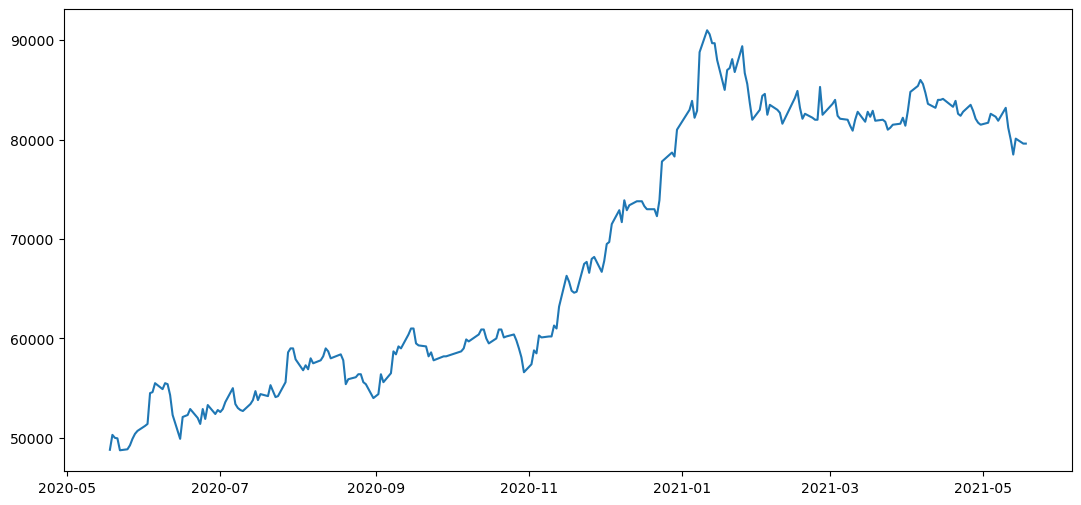

In [4]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6    # matlab 차트의 기본 크기를 13, 6으로 지정해 줍니다.

# 시계열(time series) 데이터를 차트로 그려 봅시다. 특별히 더 가공하지 않아도 잘 그려집니다.
plt.plot(ts)

## STEP 2 : 각종 전처리 수행

In [5]:
ts[ts.isna()]  # 시계열(Time Series)에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Close, dtype: float64)

결측치가 없지만 연습용으로 보간을 사용해보자.

Series([], Name: Close, dtype: float64)


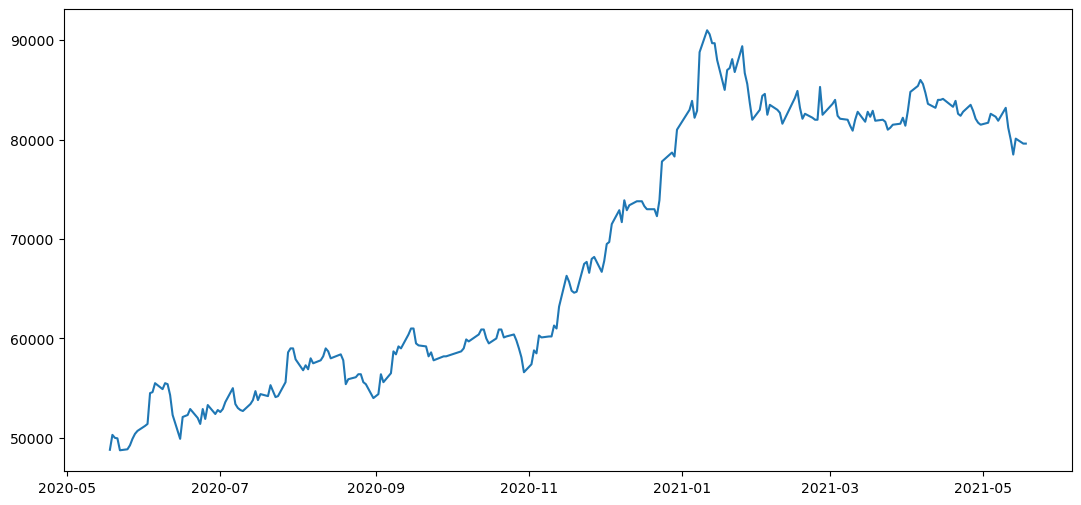

In [6]:
# 결측치가 있다면 이를 보간합니다. 보간 기준은 time을 선택합니다. 
ts=ts.interpolate(method='time')

# 보간 이후 결측치(NaN) 유무를 다시 확인합니다.
print(ts[ts.isna()])

# 다시 그래프를 확인해봅시다!
plt.plot(ts)

**시계열 데이터의 통계적 특성을 좀 더 명료하게 시각화**

- 일정 시간 내 구간 통계치(Rolling Statistics)를 시각화하는 함수
    - **현재 타임 스텝($t$)** 부터 **window에 주어진 타임 스텝 이전($t-d$)** 사이 **1. 구간의 평균(rolling mean, 이동평균)**과 **2. 구간의 표준편차(rolling std, 이동표준편차)**를 원본 시계열과 함께 시각화
    - **`window`:** 이동평균과 이동표준편차에서의 특정 개수($d)$

이동평균: $$E(X_t + X_{t+1} + X_{t+2} + \ldots + X_{t+d-1})$$

이동표준편차: $$\sigma(X_t + X_{t+1} + X_{t+2} + \ldots + X_{t+d-1})$$

In [7]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

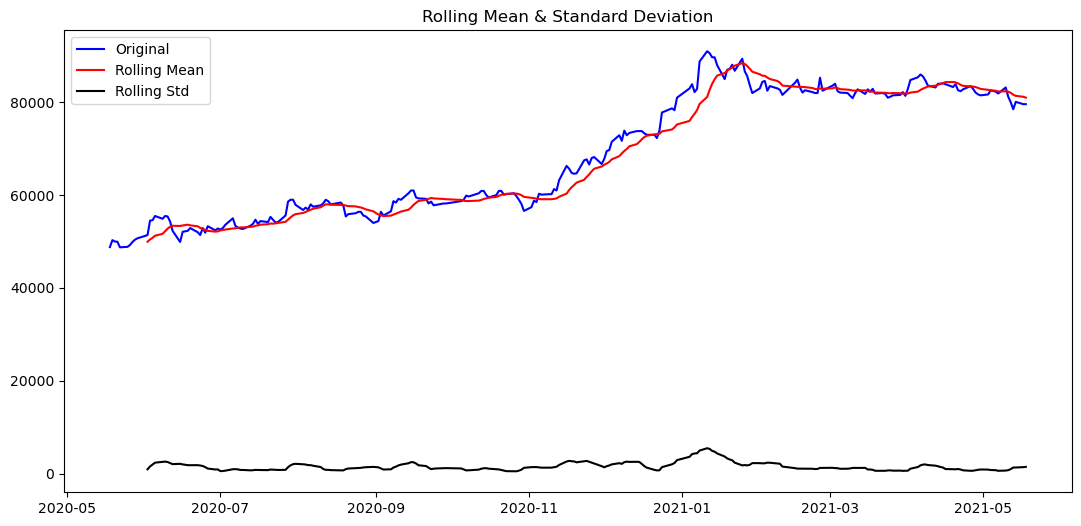

In [8]:
plot_rolling_statistics(ts)

- 이동표준편차가 매우 작다.
- 이동평균이 증가하고 있으므로 stationary 데이터는 아니다.

## STEP 3 : 시계열 안정성 분석

## __Staionary 여부를 체크하는 통계적 방법__

### **Augmented Dickey-Fuller Test (ADF Test)**

- 시계열 데이터의 안정성(stationary)을 테스트하는 통계적 방법
    1. **‘주어진 시계열 데이터가 안정적이지 않다’**라는 **귀무가설(Null Hypothesis)**를 세운 후,
    2. 통계적 가설 검정 과정을 통해 이 **귀무가설이 기각될 경우**에
    3. **‘이 시계열 데이터가 안정적이다’**라는 **대립가설(Alternative Hypothesis)**을 채택  
    
### **statsmodels 패키지와 adfuller 메서드**

- **statsmodels 패키지**: R에서 제공하는 통계검정, 시계열분석 등의 기능을 파이썬에서도 이용할 수 있도록 하는 강력한 통계 패키지
- statsmodels 패키지에서 제공하는 adfuller 메서드: 주어진 timeseries에 대한 Augmented Dickey-Fuller Test를 수행

In [9]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [10]:
augmented_dickey_fuller_test(ts)

Results of Dickey-Fuller Test:
Test Statistic                  -1.222649
p-value                          0.663778
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


p-value가 0.05 이상 (0.663778)이므로 귀무가설을 기각할 수 없음.  
→ 이 시계열 데이터는 안정적인 데이터라고 할 수 없음.

## __Staionary한 데이터로 변환하기__

### 안정적이지 않은 시계열 분석하기

- 안정적이지 않은 시계열을 분석하려면 이것을 안정적인 시계열로 바꿔야 함.
    1. 정성적인 분석을 통해 보다 안정적(stationary)인 특성을 가지도록 **기존의 시계열 데이터를 가공/변형**하는 시도
    2. **시계열 분해(Time series decomposition) 기법**을 적용

### **1. 보다 Stationary한 시계열로 가공하기**

**1-1. 로그함수 변환**

- 시간 추이에 따라 분산 달라지므로 로그 함수 변환이 도움이 됨

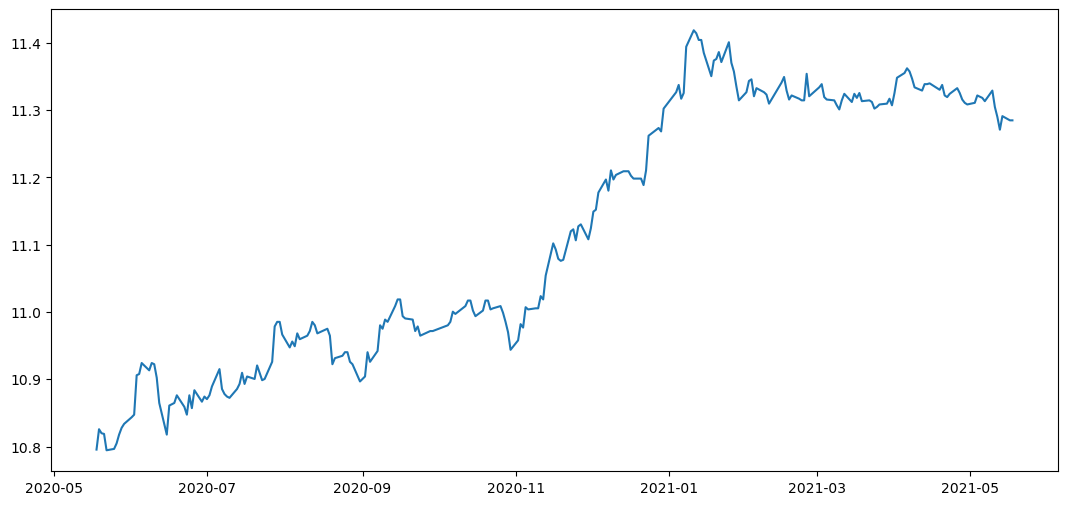

In [11]:
# 로그 변환
ts_log = np.log(ts)
plt.plot(ts_log)

In [12]:
# 로그 변환 효과 확인
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


p-value가 약간 감소 (0.663778 → 0.590148). 여전히 귀무가설을 반박할 수 없음.

### **시계열 분해(Time series decomposition)**

- **`seasonal_decompose` 메서드**
    - statsmodels 라이브러리에 포함된 메서드
    - 시계열 안에 존재하는 trend, seasonality를 직접 분리할 수 있는 기능

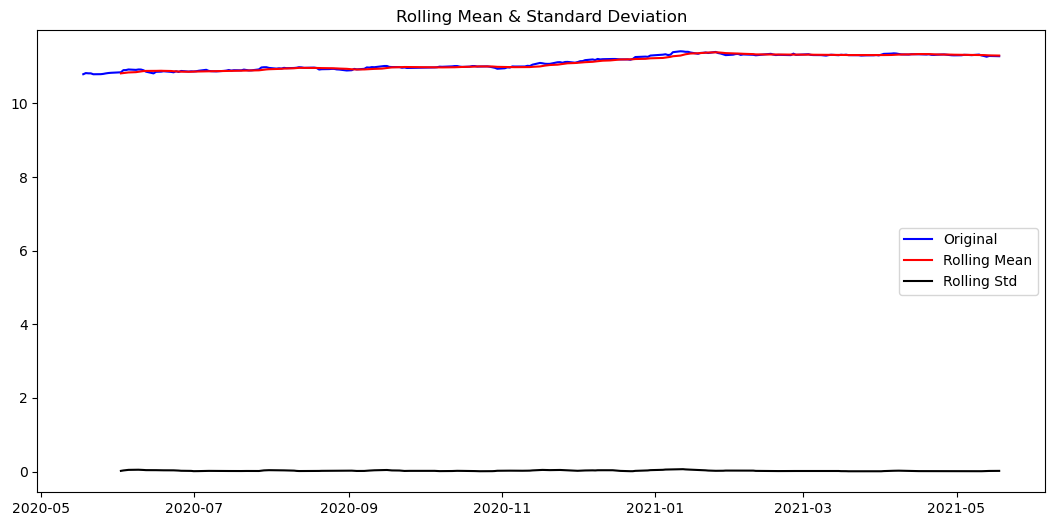

Results of Dickey-Fuller Test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


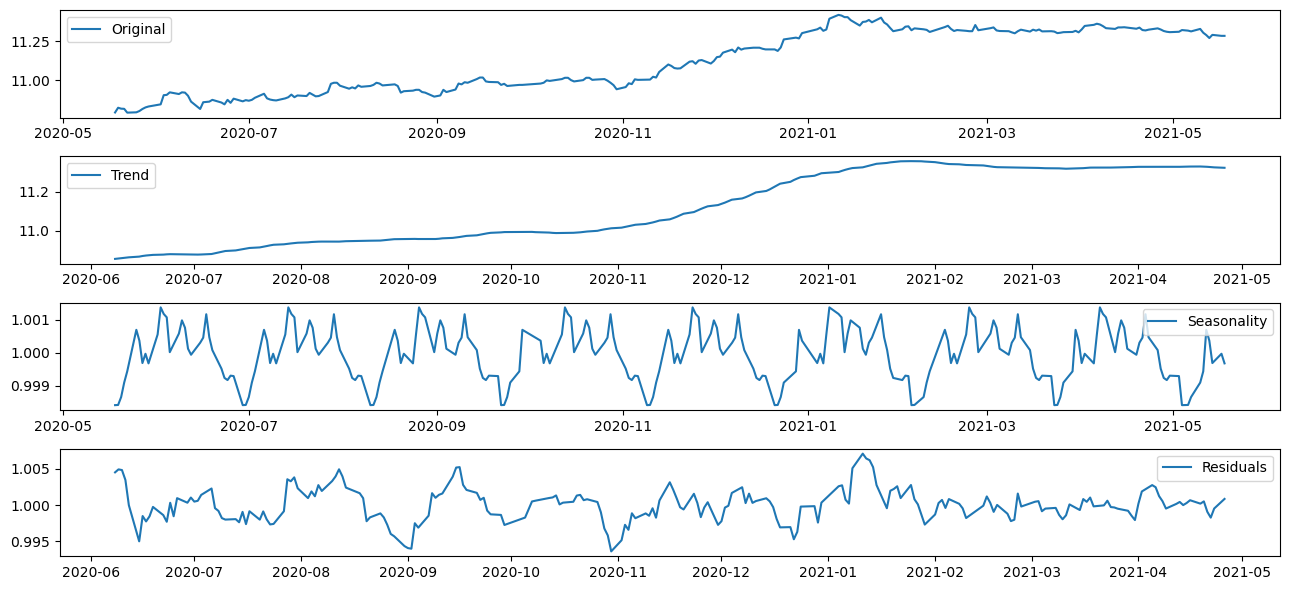

In [13]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
# Residual = Original 시계열에서 Trend와 Seasonality를 제거하고 난 나머지

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')

plt.tight_layout()

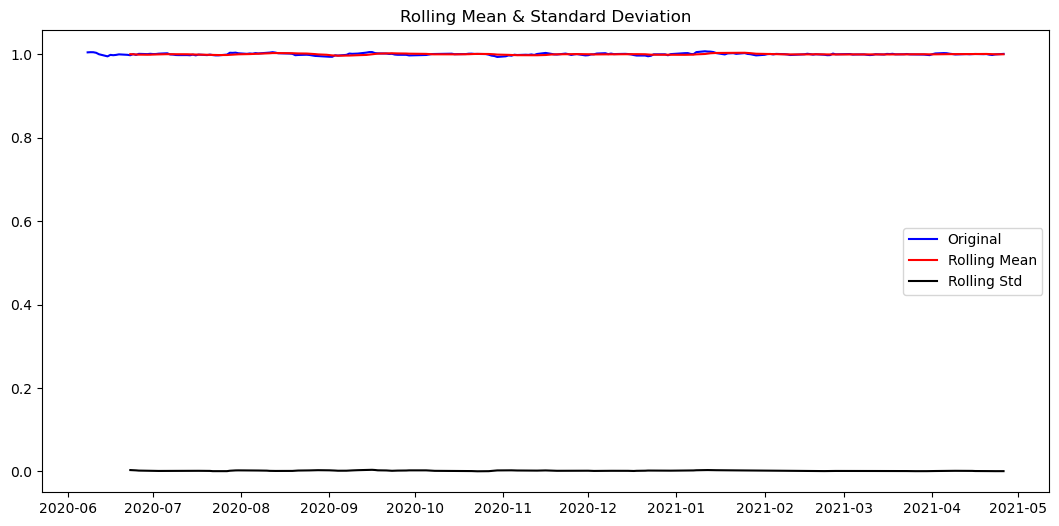

In [14]:
# Residual에 대해 안정성 여부 파악
plt.rcParams["figure.figsize"] = (13,6)
plot_rolling_statistics(residual)

In [15]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.187586e+00
p-value                        6.234854e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64


Decomposing을 통해 얻어진 Residual은 압도적으로 낮은 p-value를 보여줌  
→ 귀무가설(주어진 시계열 데이터가 안정적이지 않다)을 반박  
→ 시계열데이터가 안정적으로 변함

## STEP 4 : 학습, 테스트 데이터셋 생성

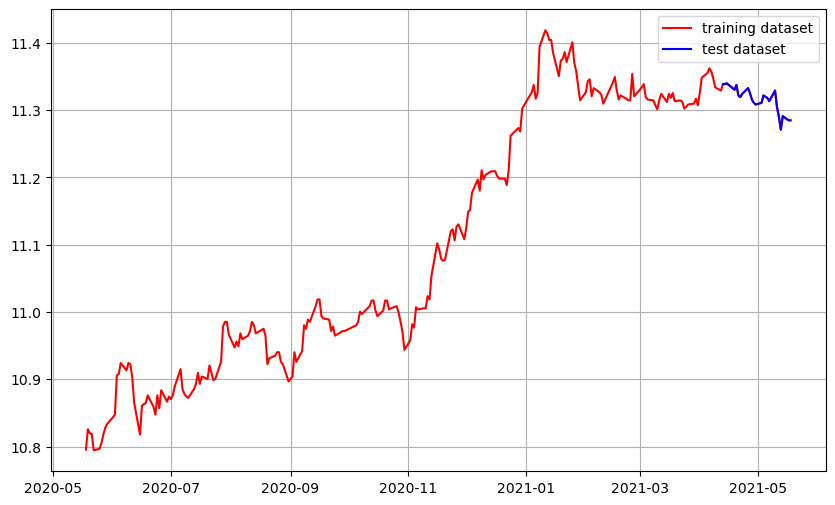

In [16]:
# 학습, 테스트 데이터셋 분리
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

## STEP 5 : 적정 ARIMA 모수 찾기

### **ARIMA 모델의 모수 p, q, d**

- `ARIMA`를 효과적으로 활용하기 위해서는 `ARIMA`의 모수(parameter)를 잘 설정해야 함
- `p` : 자기회귀 모형(AR)의 시차
- `q` : 이동평균 모형(MA)의 시차
- `d` : 차분 누적(I) 횟수

- `p` 와 `q` 는 일반적으로 `p + q < 2`, `p * q = 0` 인 값을 사용하는데, 이는 `p` 나 `q` 중 하나는 0이라는 뜻
    
    = 많은 시계열 데이터가 `AR`이나 `MA` 중 하나의 경향만 가지기 때문
    

- 모수 `p`, `q`, `d`를 결정하는 방법
    - **ACF(Autocorrelation Function)**
        - 시차(lag)에 따른 관측치들 사이의 관련성을 측정하는 함수
        - 주어진 시계열의 현재 값이 과거($y_{t-1}, y_{t-2}, \ldots, y_{t-n}$) 값과 어떻게 상관되는지 설명함.
        - ACF plot에서 X 축은 상관 계수를 나타냄, y축은 시차 수를 나타냄
    - **PACF(Partial Autocorrelation Function)**
        - 다른 관측치의 영향력을 배제하고 두 시차의 관측치 간 관련성을 측정하는 함수
        - k 이외의 모든 시차를 갖는 관측치($y_{t-1}, y_{t-2}, \ldots, y_{t-k+1}$)의 영향력을 배제한 가운데 특정 두 관측치, $y_t$와 $y_{t-k}$가 얼마나 관련이 있는지 나타내는 척도.

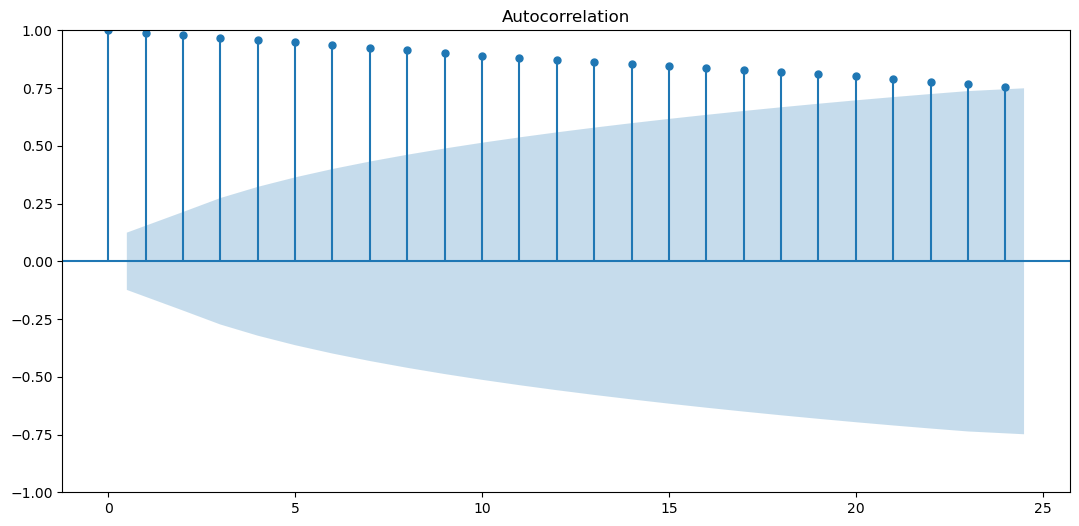

In [17]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plt.show()

- 점차적으로 감소, `AR(1)` 모델에 유사한 형태를 보이고 있음
- `q`에 대해서는 적합한 값이 없어 보임
- `MA`를 고려할 필요가 없다면 `q=0`으로 둘 수 있음
- `q`를 바꿔 가면서 확인해 보는 것도 좋음.

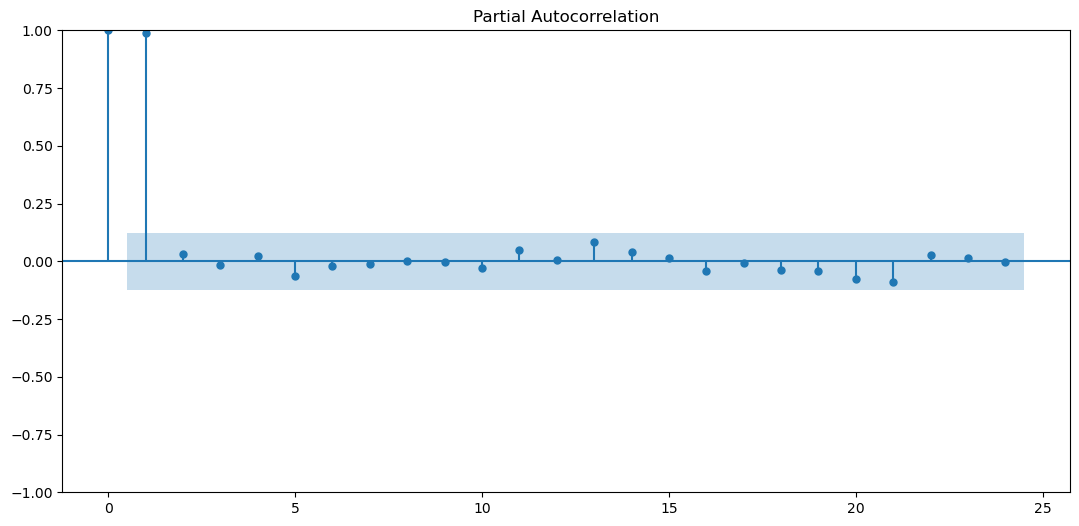

In [18]:
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

- `p`가 2 이상인 구간에서 `PACF`는 거의 0에 가까워지고 있음 (`p = 2`)
- `PACF`가 0이라는 의미는 현재 데이터와 `p` 시점 떨어진 이전의 데이터는 상관도가 0, 즉 아무 상관 없는 데이터이기 때문에 고려할 필요가 없다는 뜻

Results of Dickey-Fuller Test:
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64


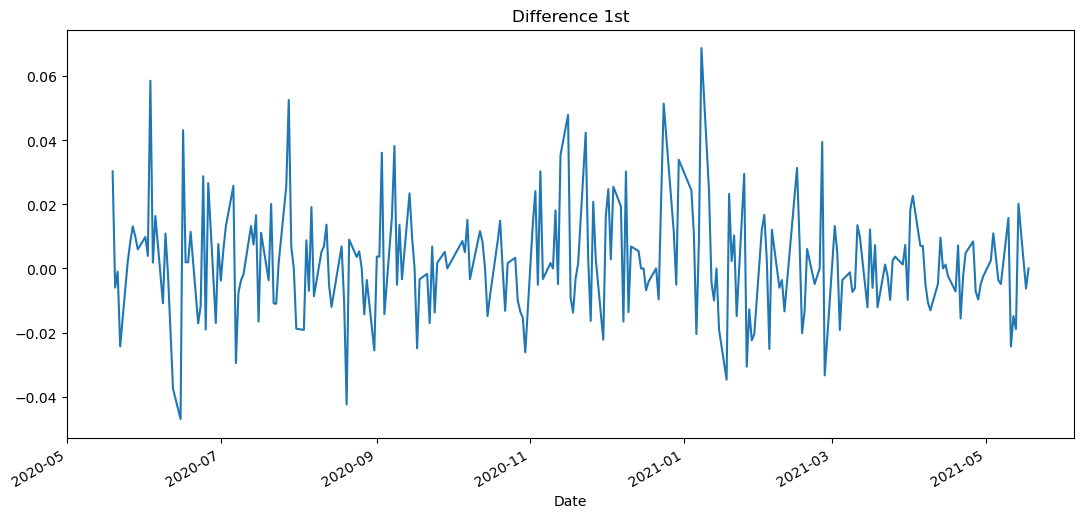

In [19]:
# 차분 안정성 확인 -> d 구하기
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

p value이 0에 수렴. (`d = 0`)

## STEP 6 : ARIMA 모델 훈련과 테스트

In [20]:
import warnings
warnings.filterwarnings('ignore') #경고 무시

from statsmodels.tsa.arima.model import ARIMA

# Build and Train  Model
model = ARIMA(train_data, order=(2, 0, 1)) # 모수는 이전 그래프를 참고 
fitted_model = model.fit() 

print(fitted_model.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 583.361
Date:                Thu, 29 Feb 2024   AIC                          -1156.722
Time:                        22:48:44   BIC                          -1139.642
Sample:                             0   HQIC                         -1149.828
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.0896      0.129     86.277      0.000      10.838      11.342
ar.L1          0.7739      1.821      0.425      0.671      -2.796       4.344
ar.L2          0.2191      1.811      0.121      0.9

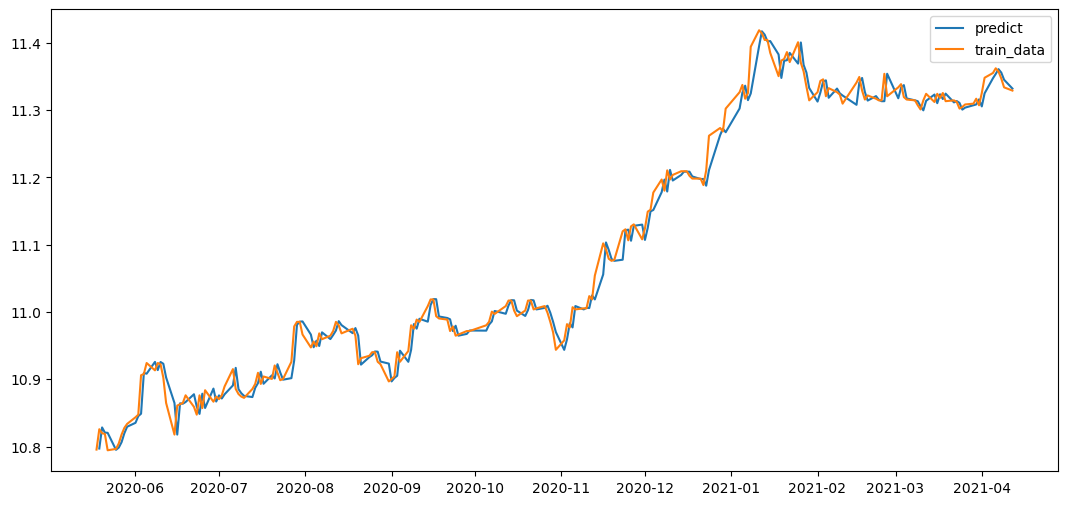

In [21]:
# ARIMA 모델 훈련 결과 시각화
training_predictions = fitted_model.predict(start=train_data.index[0], end=train_data.index[-1], typ='levels')
training_predictions = training_predictions.drop(training_predictions.index[0])
plt.plot(training_predictions, label='predict')
plt.plot(train_data, label='train_data')
plt.legend()

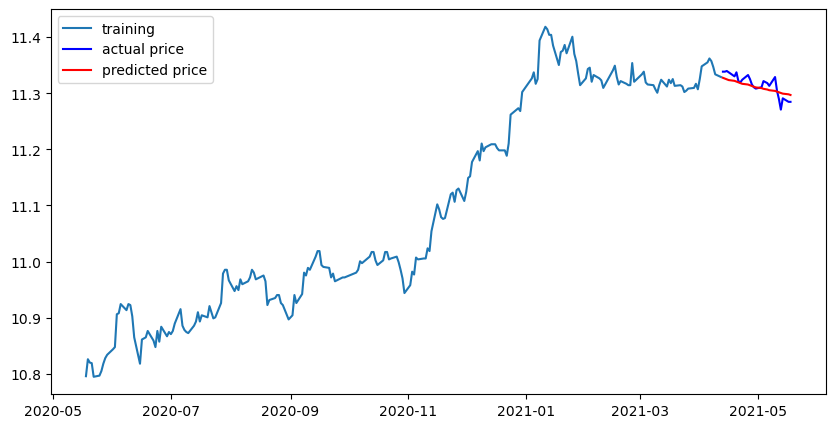

In [22]:
# Forecast : 결과가 fc에 담깁니다. 
fc_results = fitted_model.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc_results)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [23]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  1048973.6014241297
MAE:  843.7579531509092
RMSE:  1024.1941229201277
MAPE: 1.03%


In [24]:
import warnings
warnings.filterwarnings('ignore') #경고 무시

from statsmodels.tsa.arima.model import ARIMA

# Build and Train  Model
model = ARIMA(train_data, order=(2, 0, 25)) # 모수는 이전 그래프를 참고 
fitted_model = model.fit() 

print(fitted_model.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                ARIMA(2, 0, 25)   Log Likelihood                 592.307
Date:                Thu, 29 Feb 2024   AIC                          -1126.614
Time:                        22:48:55   BIC                          -1027.547
Sample:                             0   HQIC                         -1086.630
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.0750      0.132     83.698      0.000      10.816      11.334
ar.L1          1.2566      1.901      0.661      0.509      -2.469       4.982
ar.L2         -0.2627      1.884     -0.139      0.8

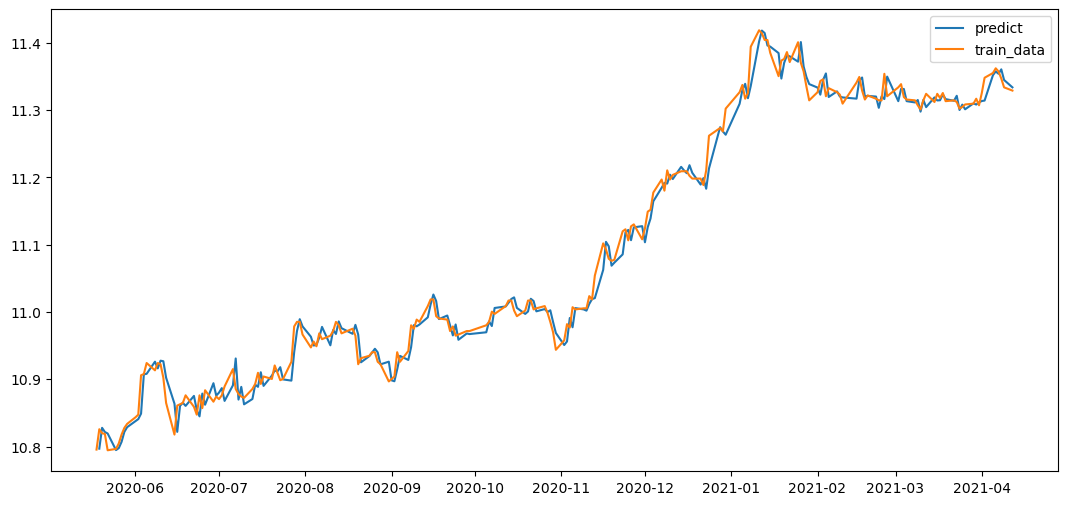

In [25]:
# ARIMA 모델 훈련 결과 시각화
training_predictions = fitted_model.predict(start=train_data.index[0], end=train_data.index[-1], typ='levels')
training_predictions = training_predictions.drop(training_predictions.index[0])
plt.plot(training_predictions, label='predict')
plt.plot(train_data, label='train_data')
plt.legend()

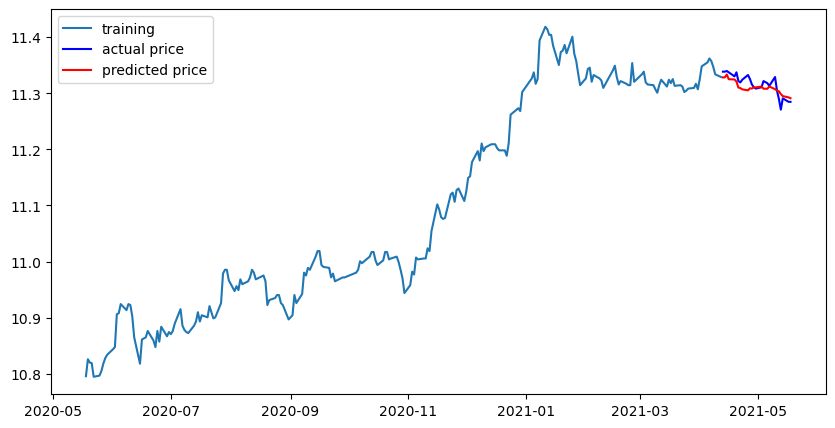

In [26]:
# Forecast : 결과가 fc에 담깁니다. 
fc_results = fitted_model.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc_results)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [27]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  1106326.5588860977
MAE:  854.5461748576938
RMSE:  1051.8205925375762
MAPE: 1.04%


d = 1이었을 때  
MSE:  1048973.6014241297  
MAE:  843.7579531509092  
RMSE:  1024.1941229201277  
MAPE: 1.03%  
였으므로, d값을 증가시켰을 때 (R)MSE 값이 감소하였다. 그러나 MAE값은 증가했으므로, 성능이 완전히 좋아졌다고 말하기 어렵다.

# Meta
## STEP 1 : 시계열 데이터 준비

In [28]:
# Time Series 생성
df_meta = pd.read_csv('Meta.csv', index_col = 'Date', parse_dates = True)
ts_meta = df_meta['Close']
ts_meta

Date
2023-02-28    174.940002
2023-03-01    173.419998
2023-03-02    174.529999
2023-03-03    185.250000
2023-03-06    184.899994
                 ...    
2024-02-22    486.130005
2024-02-23    484.029999
2024-02-26    481.739990
2024-02-27    487.049988
2024-02-28    484.019989
Name: Close, Length: 252, dtype: float64

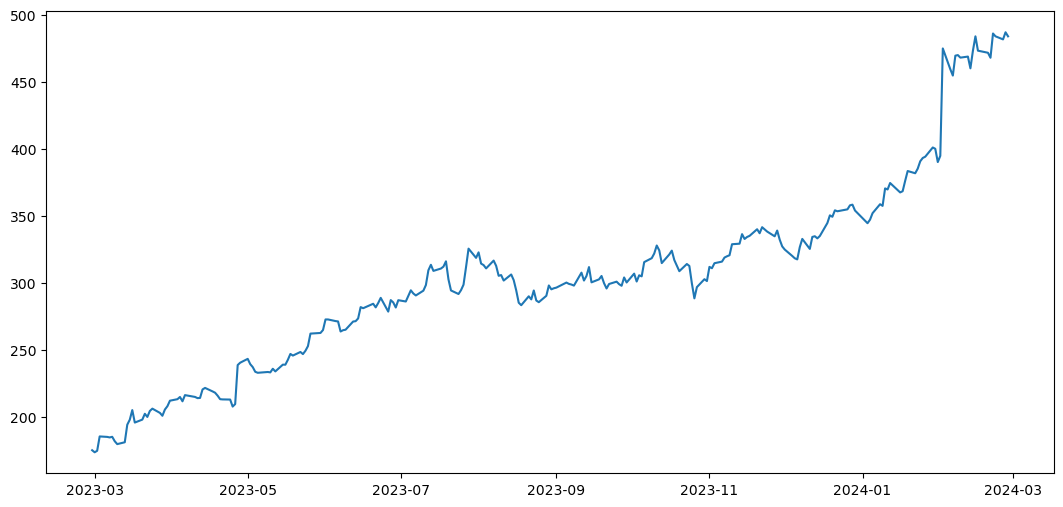

In [29]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6    # matlab 차트의 기본 크기를 13, 6으로 지정해 줍니다.

# 시계열(time series) 데이터를 차트로 그려 봅시다. 특별히 더 가공하지 않아도 잘 그려집니다.
plt.plot(ts_meta)

## STEP 2 : 각종 전처리 수행

In [30]:
ts_meta[ts_meta.isna()]  # 시계열(Time Series)에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Close, dtype: float64)

결측치가 없지만 연습용으로 보간을 사용해보자.

Series([], Name: Close, dtype: float64)


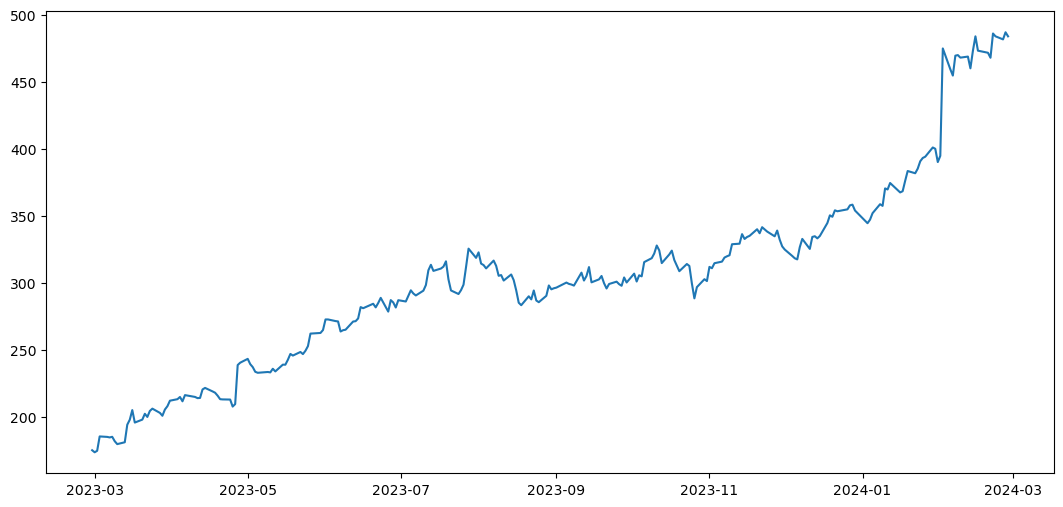

In [31]:
# 결측치가 있다면 이를 보간합니다. 보간 기준은 time을 선택합니다. 
ts_meta=ts_meta.interpolate(method='time')

# 보간 이후 결측치(NaN) 유무를 다시 확인합니다.
print(ts_meta[ts_meta.isna()])

# 다시 그래프를 확인해봅시다!
plt.plot(ts_meta)

**시계열 데이터의 통계적 특성을 좀 더 명료하게 시각화**

- 일정 시간 내 구간 통계치(Rolling Statistics)를 시각화하는 함수
    - **현재 타임 스텝($t$)** 부터 **window에 주어진 타임 스텝 이전($t-d$)** 사이 **1. 구간의 평균(rolling mean, 이동평균)**과 **2. 구간의 표준편차(rolling std, 이동표준편차)**를 원본 시계열과 함께 시각화
    - **`window`:** 이동평균과 이동표준편차에서의 특정 개수($d)$

이동평균: $$E(X_t + X_{t+1} + X_{t+2} + \ldots + X_{t+d-1})$$

이동표준편차: $$\sigma(X_t + X_{t+1} + X_{t+2} + \ldots + X_{t+d-1})$$

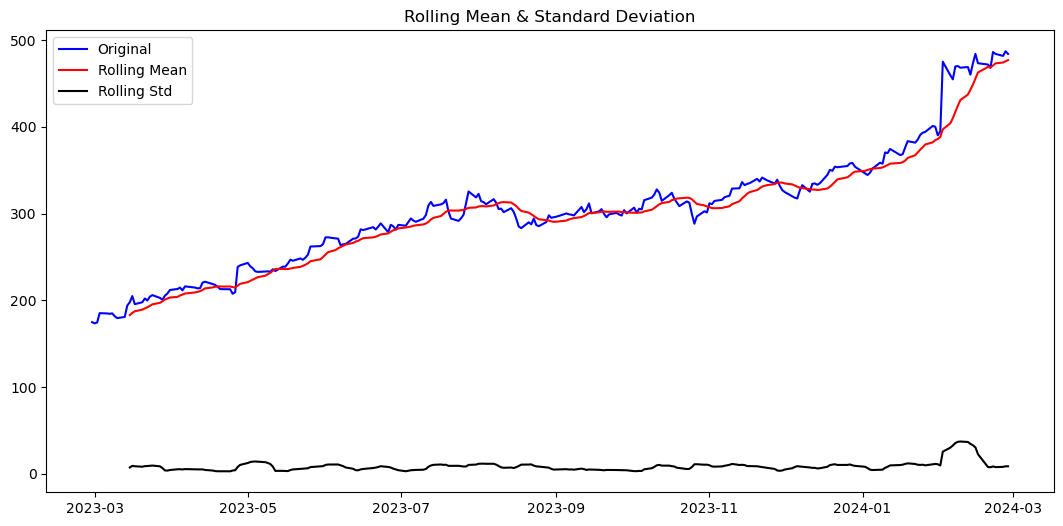

In [32]:
plot_rolling_statistics(ts_meta, window = 12)

- 이동표준편차가 매우 작다.
- 이동평균이 증가하다가 약간 감소하고 있으므로 stationary 데이터는 아니다.

## STEP 3 : 시계열 안정성 분석

## __Staionary 여부를 체크하는 통계적 방법__

### **Augmented Dickey-Fuller Test (ADF Test)**

- 시계열 데이터의 안정성(stationary)을 테스트하는 통계적 방법
    1. **‘주어진 시계열 데이터가 안정적이지 않다’**라는 **귀무가설(Null Hypothesis)**를 세운 후,
    2. 통계적 가설 검정 과정을 통해 이 **귀무가설이 기각될 경우**에
    3. **‘이 시계열 데이터가 안정적이다’**라는 **대립가설(Alternative Hypothesis)**을 채택  
    
### **statsmodels 패키지와 adfuller 메서드**

- **statsmodels 패키지**: R에서 제공하는 통계검정, 시계열분석 등의 기능을 파이썬에서도 이용할 수 있도록 하는 강력한 통계 패키지
- statsmodels 패키지에서 제공하는 adfuller 메서드: 주어진 timeseries에 대한 Augmented Dickey-Fuller Test를 수행

In [33]:
augmented_dickey_fuller_test(ts_meta)

Results of Dickey-Fuller Test:
Test Statistic                   0.605381
p-value                          0.987748
#Lags Used                       2.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


p-value가 0.05 이상 (0.987748)이므로 귀무가설을 기각할 수 없음.  
→ 이 시계열 데이터는 안정적인 데이터라고 할 수 없음.

## __Staionary한 데이터로 변환하기__

### 안정적이지 않은 시계열 분석하기

- 안정적이지 않은 시계열을 분석하려면 이것을 안정적인 시계열로 바꿔야 함.
    1. 정성적인 분석을 통해 보다 안정적(stationary)인 특성을 가지도록 **기존의 시계열 데이터를 가공/변형**하는 시도
    2. **시계열 분해(Time series decomposition) 기법**을 적용

### **1. 보다 Stationary한 시계열로 가공하기**

**1-1. 로그함수 변환**

- 시간 추이에 따라 분산 달라지므로 로그 함수 변환이 도움이 됨

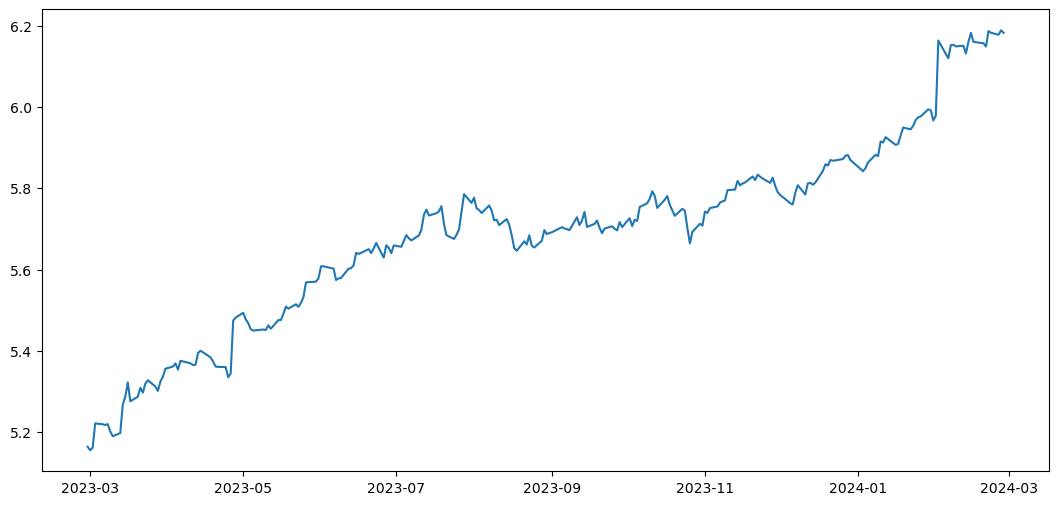

In [34]:
# 로그 변환
ts_meta_log = np.log(ts_meta)
plt.plot(ts_meta_log)

In [35]:
# 로그 변환 효과 확인
augmented_dickey_fuller_test(ts_meta_log)

Results of Dickey-Fuller Test:
Test Statistic                  -0.931434
p-value                          0.777445
#Lags Used                       0.000000
Number of Observations Used    251.000000
Critical Value (1%)             -3.456674
Critical Value (5%)             -2.873125
Critical Value (10%)            -2.572944
dtype: float64


p-value가 약간 감소 (0.987748 → 0.777445). 여전히 귀무가설을 반박할 수 없음.

### **시계열 분해(Time series decomposition)**

- **`seasonal_decompose` 메서드**
    - statsmodels 라이브러리에 포함된 메서드
    - 시계열 안에 존재하는 trend, seasonality를 직접 분리할 수 있는 기능

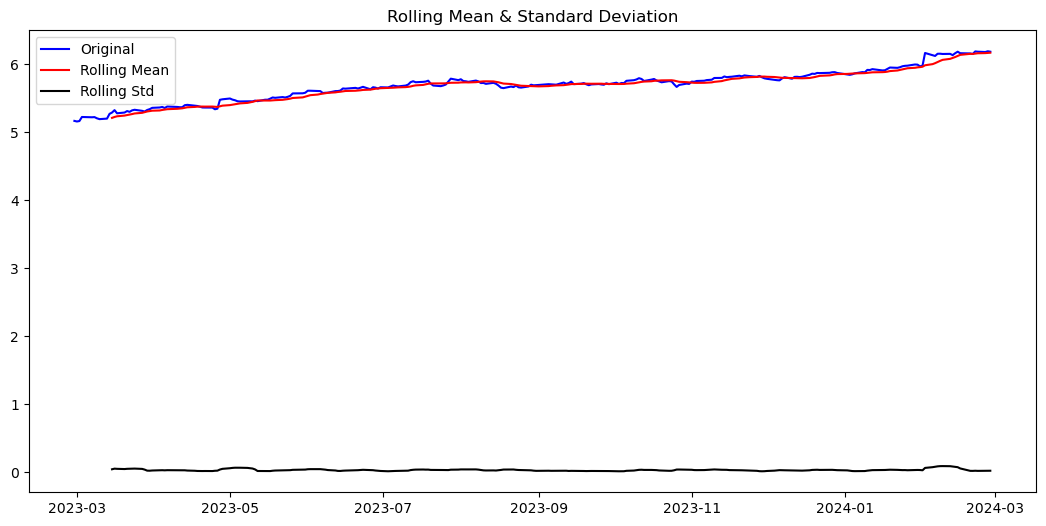

Results of Dickey-Fuller Test:
Test Statistic                  -0.931434
p-value                          0.777445
#Lags Used                       0.000000
Number of Observations Used    251.000000
Critical Value (1%)             -3.456674
Critical Value (5%)             -2.873125
Critical Value (10%)            -2.572944
dtype: float64


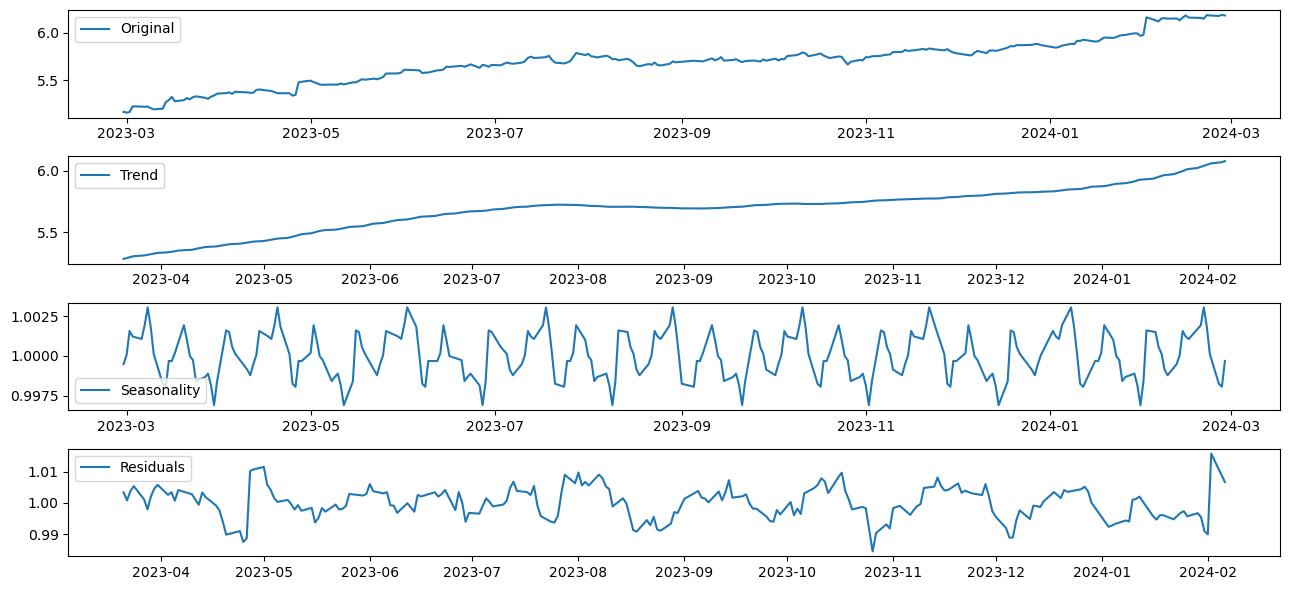

In [36]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_meta_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_meta_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_meta_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
# Residual = Original 시계열에서 Trend와 Seasonality를 제거하고 난 나머지

plt.subplot(411)
plt.plot(ts_meta_log, label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')

plt.tight_layout()

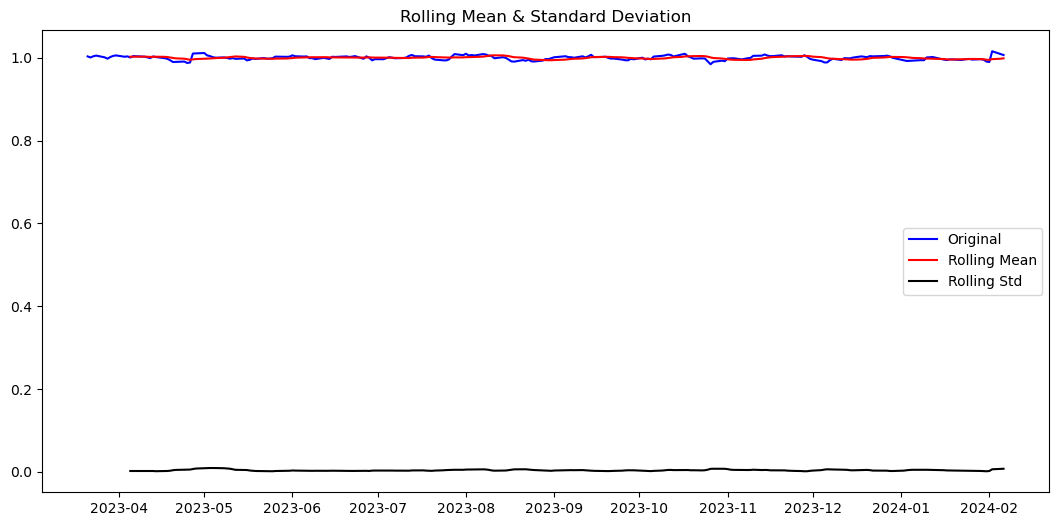

In [37]:
# Residual에 대해 안정성 여부 파악
plt.rcParams["figure.figsize"] = (13,6)
plot_rolling_statistics(residual)

In [38]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.368653e+00
p-value                        2.375027e-08
#Lags Used                     1.000000e+01
Number of Observations Used    2.110000e+02
Critical Value (1%)           -3.461727e+00
Critical Value (5%)           -2.875337e+00
Critical Value (10%)          -2.574124e+00
dtype: float64


Decomposing을 통해 얻어진 Residual은 압도적으로 낮은 p-value를 보여줌  
→ 귀무가설(주어진 시계열 데이터가 안정적이지 않다)을 반박  
→ 시계열데이터가 안정적으로 변함

## STEP 4 : 학습, 테스트 데이터셋 생성

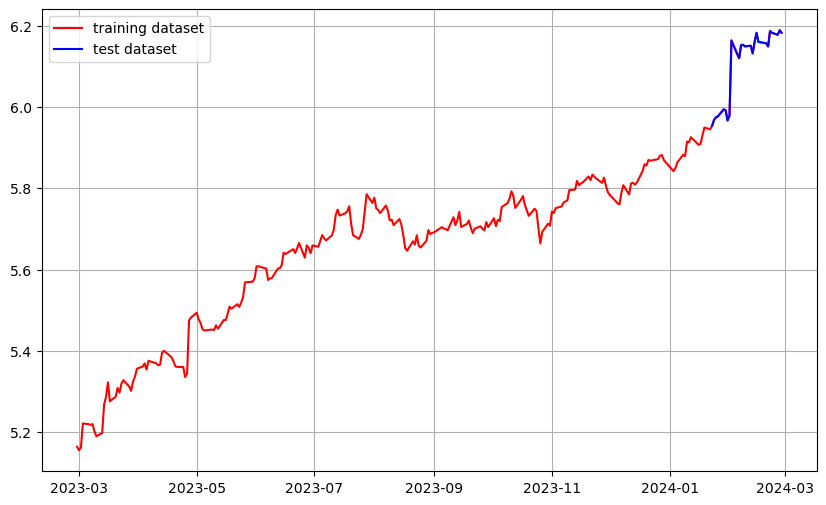

In [39]:
# 학습, 테스트 데이터셋 분리
train_data, test_data = ts_meta_log[:int(len(ts_meta_log)*0.9)], ts_meta_log[int(len(ts_meta_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_meta_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_meta_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

## STEP 5 : 적정 ARIMA 모수 찾기

### **ARIMA 모델의 모수 p, q, d**

- `ARIMA`를 효과적으로 활용하기 위해서는 `ARIMA`의 모수(parameter)를 잘 설정해야 함
- `p` : 자기회귀 모형(AR)의 시차
- `q` : 이동평균 모형(MA)의 시차
- `d` : 차분 누적(I) 횟수

- `p` 와 `q` 는 일반적으로 `p + q < 2`, `p * q = 0` 인 값을 사용하는데, 이는 `p` 나 `q` 중 하나는 0이라는 뜻
    
    = 많은 시계열 데이터가 `AR`이나 `MA` 중 하나의 경향만 가지기 때문
    

- 모수 `p`, `q`, `d`를 결정하는 방법
    - **ACF(Autocorrelation Function)**
        - 시차(lag)에 따른 관측치들 사이의 관련성을 측정하는 함수
        - 주어진 시계열의 현재 값이 과거($y_{t-1}, y_{t-2}, \ldots, y_{t-n}$) 값과 어떻게 상관되는지 설명함.
        - ACF plot에서 X 축은 상관 계수를 나타냄, y축은 시차 수를 나타냄
    - **PACF(Partial Autocorrelation Function)**
        - 다른 관측치의 영향력을 배제하고 두 시차의 관측치 간 관련성을 측정하는 함수
        - k 이외의 모든 시차를 갖는 관측치($y_{t-1}, y_{t-2}, \ldots, y_{t-k+1}$)의 영향력을 배제한 가운데 특정 두 관측치, $y_t$와 $y_{t-k}$가 얼마나 관련이 있는지 나타내는 척도.

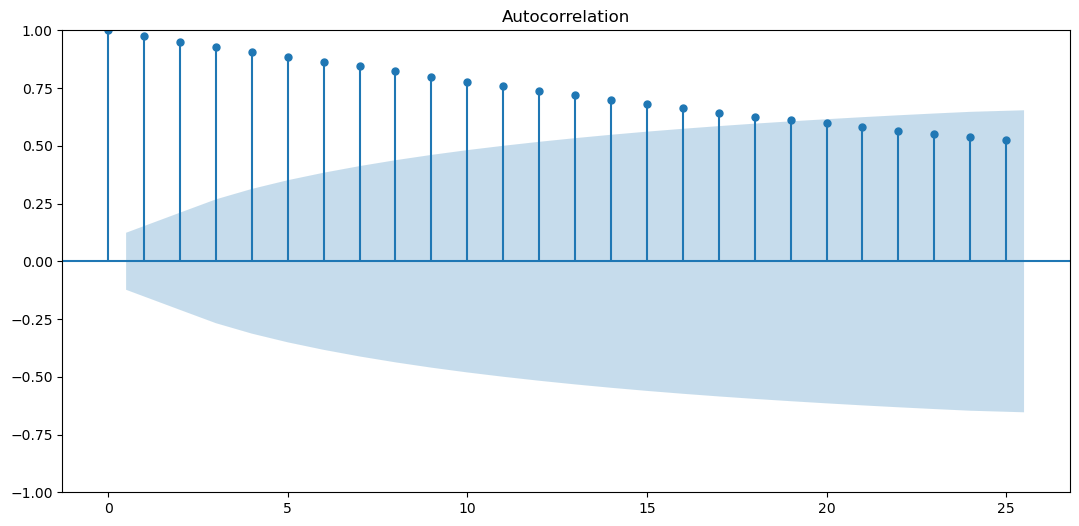

In [40]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_meta_log)   # ACF : Autocorrelation 그래프 그리기
plt.show()

- 점차적으로 감소, `AR(1)` 모델에 유사한 형태를 보이고 있음
- `q`에 대해서는 적합한 값이 없어 보임
- `MA`를 고려할 필요가 없다면 `q=0`으로 둘 수 있음
- `q`를 바꿔 가면서 확인해 보는 것도 좋음.

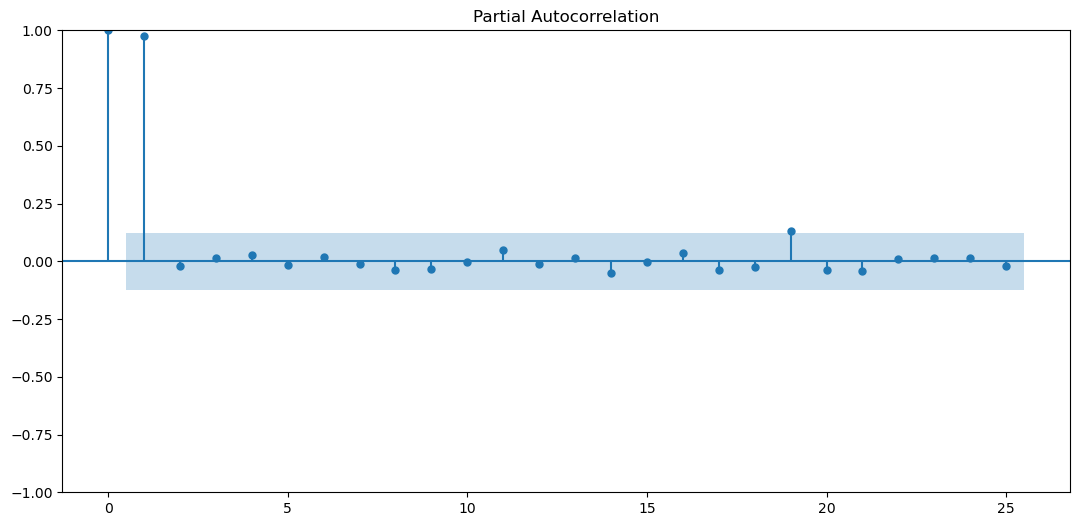

In [41]:
plot_pacf(ts_meta_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

- `p`가 2 이상인 구간에서 `PACF`는 거의 0에 가까워지고 있음 (`p = 2`)
- `PACF`가 0이라는 의미는 현재 데이터와 `p` 시점 떨어진 이전의 데이터는 상관도가 0, 즉 아무 상관 없는 데이터이기 때문에 고려할 필요가 없다는 뜻

Results of Dickey-Fuller Test:
Test Statistic                -1.271503e+01
p-value                        1.010825e-23
#Lags Used                     1.000000e+00
Number of Observations Used    2.490000e+02
Critical Value (1%)           -3.456888e+00
Critical Value (5%)           -2.873219e+00
Critical Value (10%)          -2.572994e+00
dtype: float64


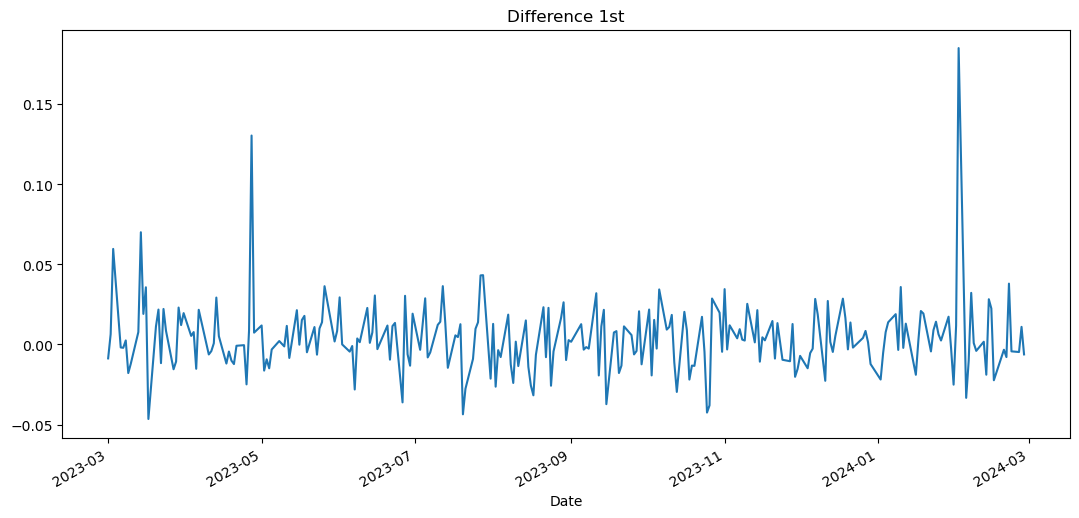

In [42]:
# 차분 안정성 확인 -> d 구하기
# 1차 차분 구하기
diff_1 = ts_meta_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

p value이 0에 수렴. (`d = 0`)

## STEP 6 : ARIMA 모델 훈련과 테스트

In [43]:
import warnings
warnings.filterwarnings('ignore') #경고 무시

from statsmodels.tsa.arima.model import ARIMA

# Build and Train  Model
model = ARIMA(train_data, order=(2, 0, 2)) # 모수는 이전 그래프를 참고 
fitted_model = model.fit() 

print(fitted_model.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  226
Model:                 ARIMA(2, 0, 2)   Log Likelihood                 559.038
Date:                Thu, 29 Feb 2024   AIC                          -1106.076
Time:                        22:49:01   BIC                          -1085.553
Sample:                             0   HQIC                         -1097.794
                                - 226                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.7771      0.633      9.130      0.000       4.537       7.017
ar.L1          1.4797      0.697      2.122      0.034       0.113       2.846
ar.L2         -0.4810      0.696     -0.692      0.4

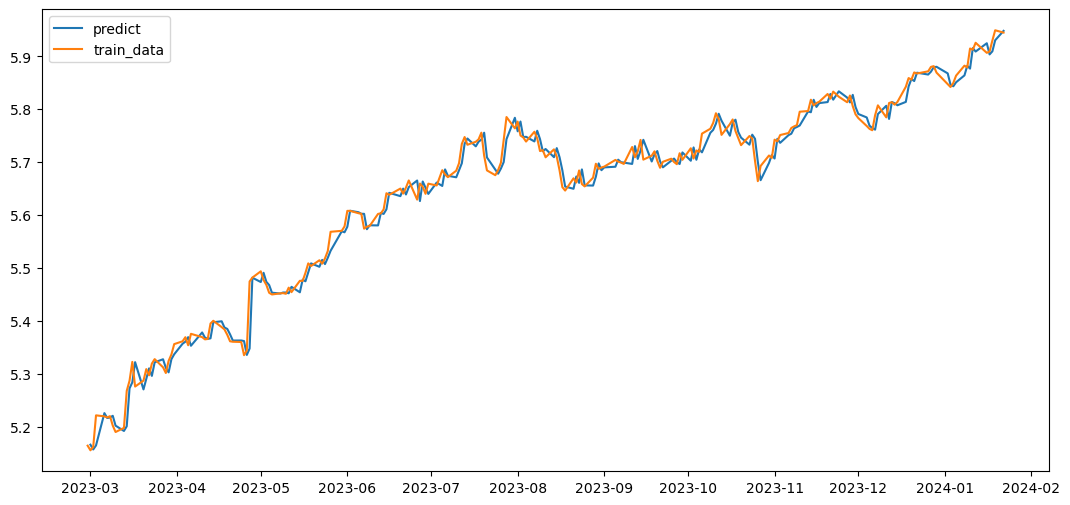

In [44]:
# ARIMA 모델 훈련 결과 시각화
skip_lags = max(3, 2, 20)
training_predictions = fitted_model.predict(start=train_data.index[0], end=train_data.index[-1], typ='levels')
training_predictions = training_predictions.drop(training_predictions.index[0])
plt.plot(training_predictions, label='predict')
plt.plot(train_data, label='train_data')
plt.legend()

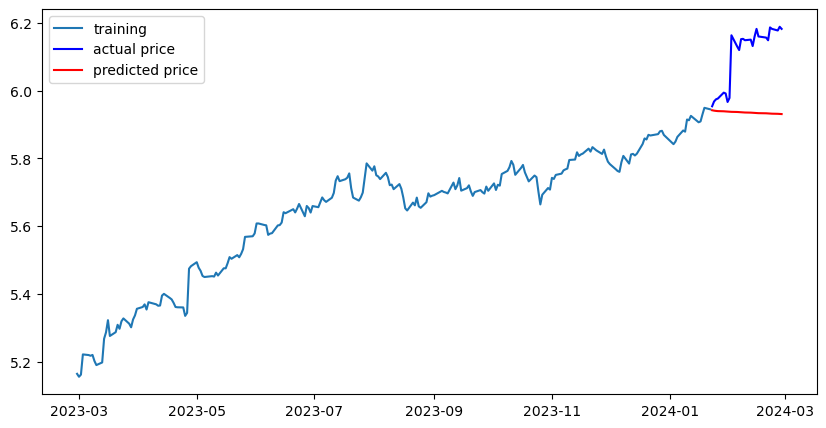

In [45]:
# Forecast : 결과가 fc에 담깁니다. 
fc_results = fitted_model.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc_results)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

마지막에 급증하는 경향이 있으므로, 잘 예측되지는 않음.

In [46]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  6463.106495012205
MAE:  70.4573397630213
RMSE:  80.39344808510334
MAPE: 15.04%


In [47]:
import warnings
warnings.filterwarnings('ignore') #경고 무시

from statsmodels.tsa.arima.model import ARIMA

# Build and Train  Model
model = ARIMA(train_data, order=(2, 1, 20)) # 모수는 이전 그래프를 참고 
fitted_model = model.fit() 

print(fitted_model.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  226
Model:                ARIMA(2, 1, 20)   Log Likelihood                 567.800
Date:                Thu, 29 Feb 2024   AIC                          -1089.599
Time:                        22:49:06   BIC                          -1011.029
Sample:                             0   HQIC                         -1057.888
                                - 226                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0981     23.627      0.004      0.997     -46.211      46.407
ar.L2          0.1080      9.972      0.011      0.991     -19.437      19.653
ma.L1         -0.0752     23.622     -0.003      0.9

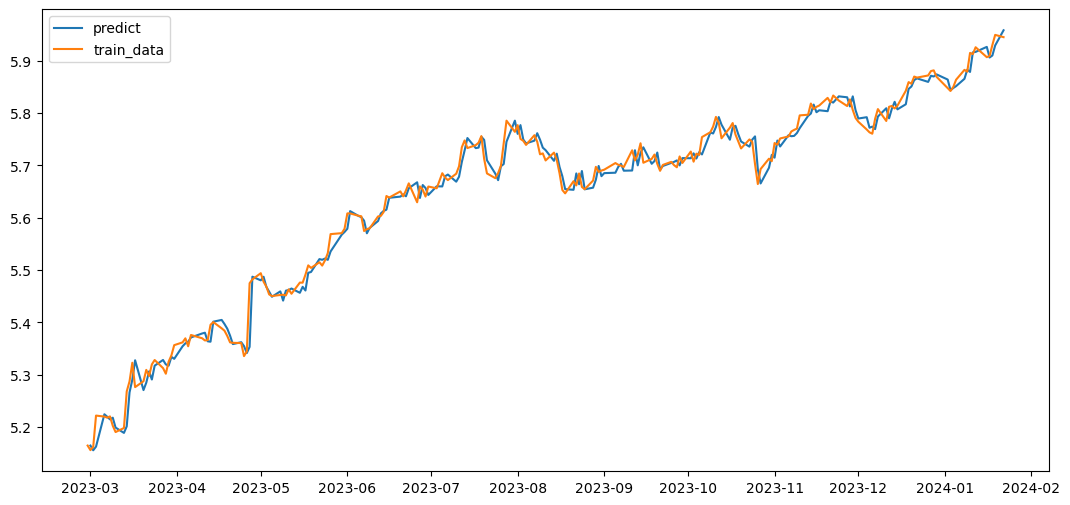

In [48]:
# ARIMA 모델 훈련 결과 시각화
skip_lags = max(3, 2, 20)
training_predictions = fitted_model.predict(start=train_data.index[0], end=train_data.index[-1], typ='levels')
training_predictions = training_predictions.drop(training_predictions.index[0])
plt.plot(training_predictions, label='predict')
plt.plot(train_data, label='train_data')
plt.legend()

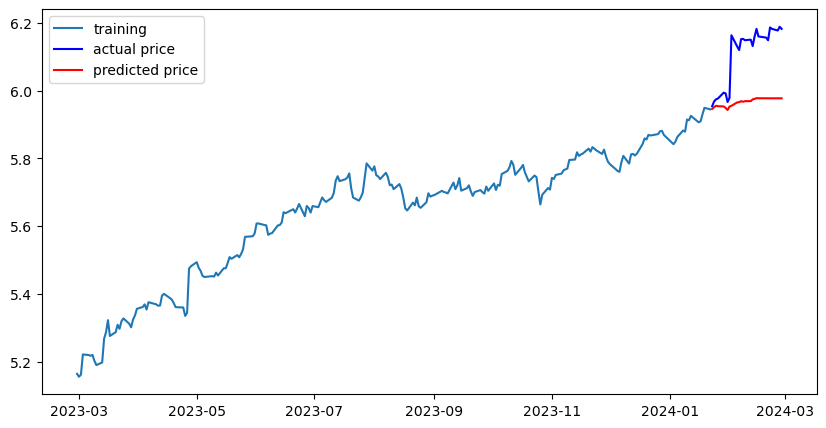

In [49]:
# Forecast : 결과가 fc에 담깁니다. 
fc_results = fitted_model.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc_results)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

마지막에 급증하는 경향이 있으므로, 잘 예측되지는 않음.

In [50]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  4599.520666266808
MAE:  58.89265879295193
RMSE:  67.81976604402884
MAPE: 12.55%


그래도 MAPE값이 3% 가량 감소했다.

# 회고
뭔가 하면서도 이게 맞나...?하고 의문이 드는 노드였습니다.  
승욱 퍼실님이랑도 잠깐 얘기했지만 이전 노드들은 그래도 어느 정도 아 이런 느낌이구나 하고 직관적으로 이해되는 것들이 있었는데,  
통계 강의 포함 시계열 데이터는 어...이건가...? 아닌가...? 하는 느낌입니다ㅋㅋㅋ  
좀 더 차근히 시간을 두고 이해하려고 노력해야겠습니다.  
마침 내일이 연휴기도 하니 어제 못들은 부분까지 보강할 수 있도록 해야겠어요.  
매번 확인해주셔서 감사합니다.